# Kmeans++

## Auxiliary functions :

### $D^2$ random distribution :

The following algorithm returns a random index using a discrete (non negative) weight distribution w.

In [6]:
random = function(w){
    n = length(w)
    # discrete cumulative distribution 
    p = cumsum(w)
    # simulate probability using Inverse Transform Sampling
    u = runif(1,0,p[n])
    # find the index of the inverse using dichotomic search
    a = 0
    b = n
    # loop invariant : a<b and p[a]<=u<p[b]
    while(b-a>1){
        c = a + (b-a)%/%2
        if (p[c]>u){
            b = c
        } else {
            a = c
        }
    }
    return(b)
}

### Euclidien distance

The following function computes the square of the euclidien distance between two vectors x and y.

In [7]:
dist2 = function(x,y){
    return (t(x-y)%*%(x-y))
}

###  Cluster partitioning

* The following algorithm returns the indexing vector for the clusters obtained by partitioning the dataset X using a set of cluster centers C.

In [8]:
iclusters = function(X, C){
    # sample size
    n = ncol(X)
    # cluster count
    k = ncol(C)
    # Cindex will contain the index of the nearest center
    Cindex = vector("double", n)
    # partitioning sample over cluster centers
    for (x in 1:n){
        d = dist2(X[,x],C[,1])
        Cindex[x] = 1
        for (c in 2:k){
            if (dist2(X[,x],C[,c]) < d){
                d = dist2(X[,x],C[,c])
                Cindex[x] = c
            }
        }
    }
    return(Cindex)
}

* The following algorithm returns the list of clusters obtained by partitioning the dataset X using a set of cluster centers C.

In [9]:
clusters = function(X, C){
    # cluster count
    k = ncol(C)
    # get the indexing vector for the clusters
    Cindex = iclusters(X,C)
    # constructing the list of clusters
    clist = vector("list", k)
    for (c in 1:k){
        index = Cindex==c
        clist[[c]] = X[,index]
    }
    return(clist)
}

## $D^2$ seeding method

The following algorithm returns a matrix of k randomly chosen initial centers from a dataset X, using the D² seeding method which works recursively as follows :

* Choose the first center $C_1$ uniformely at random from X

* Given the first $C = \{C_1,...C_{i-1}\}$ centers chosen, choose the next center $C_i$ at random from X using the probability distribution :
$\bigg(\dfrac{D(x)^2}{\sum_{x\in X} D(x)^2}\bigg)_{x\in X}$ where $D(x) = \min\big\{||x-c||:c\in C\big\}$ 

In [10]:
d2seed = function(X, k){
    # sample dimensions
    d = nrow(X)
    n = ncol(X)
    # allocate a dxk matrix for the centers
    C = matrix(NA_real_, d, k)
    # choose first center uniformely from the sample
    i = floor(runif(1,0,n))
    C[,1] = X[,i+1]
    # calculate initial weight distribution
    d2 = vector("double", n)
    for (i in 1:n){
        d2[i] = dist2(X[,i],C[,1])
    }
    # choose the next (k-1) remaining centers using the D² method
    for (c in 2:k){
        # select the next center using auxiliary function
        r = random(d2)
        C[,c] = X[,r]
        # update weight distribution
        for (i in 1:n){
            d2[i] = min(d2[i], dist2(X[,i],C[,c]))
        }
    }
    return(C)
}

## Kmeans++

The following algorithm returns a matrix of k cluster centers for a dataset X, using the Kmeans algorithm initialized with the $D^2$ seeding method. The iter argument specifies the maximum number of iterations of the optimization loop.

In [11]:
kmpp = function(X, k, iter=0){
    # sample size
    n = ncol(X)
    # initialization of cluster centers
    C = d2seed(X,k)
    # optimization loop
    repeat{
        # Cindex will contain the index of the nearest scenter
        Cindex = vector("double",n)
        # partitioning sample over cluster centers
        for (x in 1:n){
            d = dist2(X[,x],C[,1])
            Cindex[x] = 1
            for (c in 2:k){
                if (dist2(X[,x],C[,c]) < d){
                    d = dist2(X[,x],C[,c])
                    Cindex[x] = c
                }
            }
        }
        # updating cluster centers
        convergence = TRUE
        for (c in 1:k){
            index = Cindex==c
            size = sum(index)
            cluster = X[,index]
            if (size>1){
                newcenter = rowSums(cluster)/size
            } else {
                newcenter = cluster
            }            
            if (all(newcenter!=C[,c])){
                convergence = FALSE
                C[,c] = newcenter
            }
        }
        iter = iter-1
        if(convergence || iter==0){
            break
        }
    }
    return(C)
}

## Visualization

The following function performs a multidimentional plot of *k* clusters obtained from a dataset *X* using the indexing vector *index*. The vector *names* contains the labels for data coordinates while cluster colors can be specified through *col* vector.

In [125]:
pclusters = function(X, k, index, names, col = NULL){
    # dataset dimension
    d = nrow(X)
    # constructing the list of clusters
    clist = vector("list", k)
    for (c in 1:k){
        bool = index==c
        clist[[c]] = X[,bool]
    }
    # plotting
    if (length(col)==0){
        col = c(2:(k+1))
    }
    if (d==2){
        plot(clist[[1]][1,],clist[[1]][2,], col = col[1],
             xlab=names[1], ylab=names[2], xlim = c(1,5), ylim = c(1,5))
        for (c in 2:k){
            points(clist[[c]][1,],clist[[c]][2,], col = col[c],
                   xlab=names[1], ylab=names[2])
        }
    } else {
        par(mfrow=c(d,d))
        for (i in 1:d){
            for (j in 1:d){
                if (j==i){
                    par(pin=c(1.2,1.2))
                    plot(c(0, 1), c(0, 1), ann = F,  
                         type = 'n', xaxt = 'n', yaxt = 'n',)
                    text(x = 0.5, y = 0.5, paste(names[i]), 
                         cex = 1.6, col = "black")
                } else {
                    par(pin=c(1.2,1.2))
                    if (i==1 || i==d) {
                        plot(clist[[1]][i,],clist[[1]][j,], ann=FALSE,
                             col = col[1], yaxt='n', pch=20, 
                             xlim = c(1,5), ylim = c(1,5))
                    } else if (j==1 || j==d) {
                        plot(clist[[1]][i,],clist[[1]][j,], ann=FALSE,
                             col = col[1], xaxt='n', pch=20, 
                             xlim = c(1,5), ylim = c(1,5))
                    } else {
                        plot(clist[[1]][i,],clist[[1]][j,], ann=FALSE,
                             col = col[1], xaxt='n', yaxt='n', pch=20, 
                             xlim = c(1,5), ylim = c(1,5))
                    }
                    for (c in 2:k){
                        points(clist[[c]][1,],clist[[c]][2,], ann=FALSE,
                               pch=20, col = col[c], xaxt='n', yaxt='n')
                    }
                }
            }
        }
    }
}

### Testing with simulated dataset

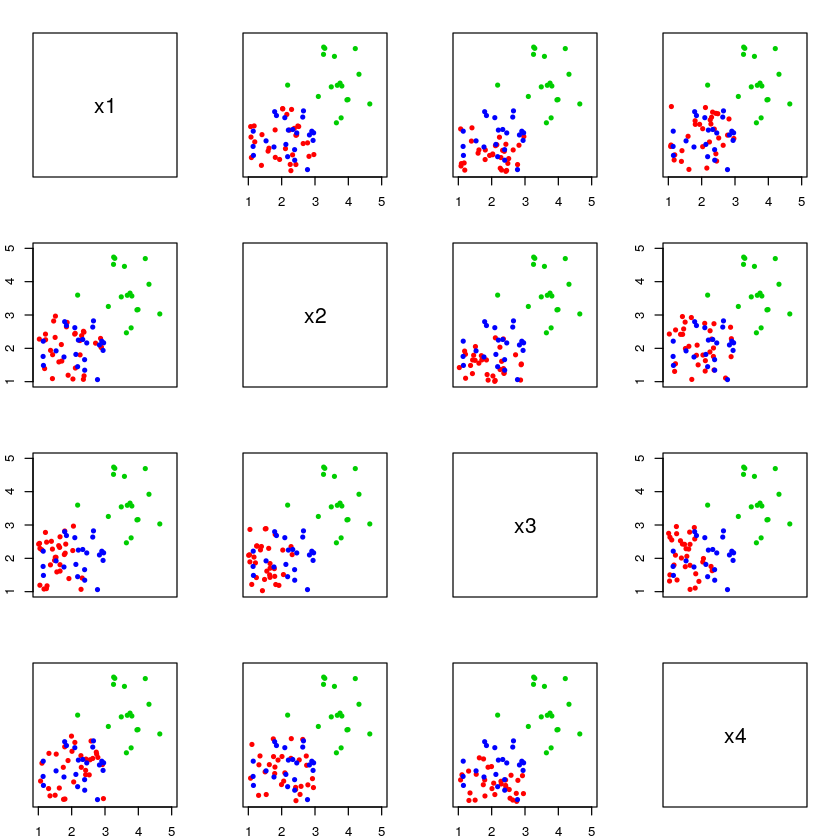

In [126]:
X = c(runif(200,1,3),runif(40,2,4),runif(40,3,5))
dim(X) = c(4,70)
Centers = kmpp(X,3)
index = iclusters(X,Centers)
#pclusters(X[1:2,],3,index,c("x1","x2","x3","x4"))
pclusters(X,3,index,c("x1","x2","x3","x4"))

In [53]:
help(par)